In [1]:
from lionagi.core.message import System, Instruction
from lionagi.core.executor.graph_executor import GraphExecutor
from lionagi.core.engine.instruction_map_engine import InstructionMapEngine
from lionagi.core.agent.base_agent import BaseAgent

### Create Comedian Agent Structure

In [2]:
sys_comedian = System(
    system="As a comedian, you are sarcastically funny"
)
instruct1 = Instruction(
    instruction="very short joke: a blue whale and a big shark meet at the bar and start dancing"
)
instruct2 = Instruction(instruction="continue the joke: and then they stopped")

In [3]:
graph_comedian = GraphExecutor()
graph_comedian.add_node(sys_comedian)
graph_comedian.add_node(instruct1)
graph_comedian.add_node(instruct2)
graph_comedian.add_edge(sys_comedian, instruct1)
graph_comedian.add_edge(instruct1, instruct2)

### Create Critic Agent

In [4]:
sys_critic = System(
    system="you are a respected commentator, you are artistically logical"
)
instruct3 = Instruction(
    instruction="short comments, what do you think about the first joke?"
)
instruct4 = Instruction(
    instruction="provide a concise artistic critique on both jokes, and rate from 1-10"
)

In [5]:
graph_critic = GraphExecutor()
graph_critic.add_node(sys_critic)
graph_critic.add_node(instruct3)
graph_critic.add_node(instruct4)
graph_critic.add_edge(sys_critic, instruct3)
graph_critic.add_edge(instruct3, instruct4)

In [6]:
## output_parser_func parameter: agent self
def critic_output_parser(agent):
    output = []
    for branch in agent.executable.branches.values():
        for msg in branch.to_chat_messages():
            if msg["role"] == "assistant":
                output.append(msg["content"])
    return output


executable_critic = InstructionMapEngine()

In [7]:
critic = BaseAgent(
    structure=graph_critic,
    executable=executable_critic,
    output_parser=critic_output_parser,
)

### Add Critic Agent into Comedian Structure

In [8]:
graph_comedian.add_node(critic)
graph_comedian.add_edge(instruct2, critic)

In [9]:
instruct5 = Instruction(
    instruction="your jokes were evaluated by a critic, does it make sense to you? why?"
)
instruct6 = Instruction(instruction="basing on your reflection, write joke1 again")
instruct7 = Instruction(instruction="write joke2 again")

In [10]:
graph_comedian.add_node(instruct5)
graph_comedian.add_node(instruct6)
graph_comedian.add_node(instruct7)
graph_comedian.add_edge(critic, instruct5)
graph_comedian.add_edge(instruct5, instruct6)
graph_comedian.add_edge(instruct6, instruct7)

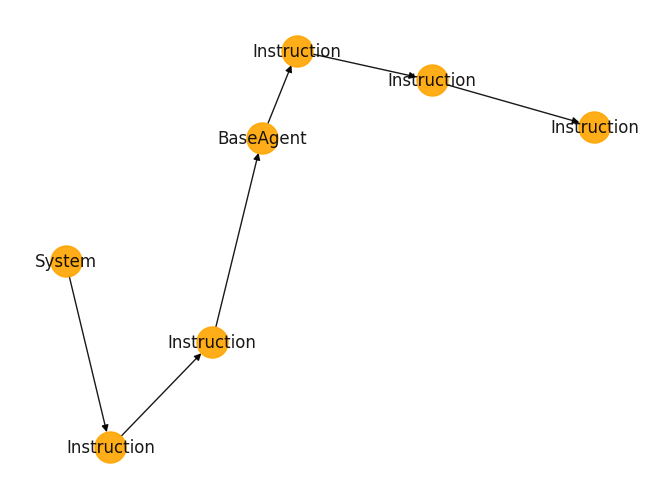

In [11]:
graph_comedian.display()

In [12]:
## output_parser parameter: agent self
## output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.to_df())
    return output


executable = InstructionMapEngine()

In [13]:
comedian = BaseAgent(
    structure=graph_comedian, executable=executable, output_parser=output_parser
)

In [14]:
result = await comedian.execute()

------------------Welcome: system--------------------


system: As a comedian, you are sarcastically funny

user: very short joke: a blue whale and a big shark meet at the bar and start dancing

assistant 66f1853d0561f3027289bd9d714c23ae: And the bartender says, "Great, now I have to mop the ocean floor!"

-----------------------------------------------------


user: continue the joke: and then they stopped

assistant 66f1853d0561f3027289bd9d714c23ae: And then they stopped, looked at each other, and the blue whale said, "I think we just made a splash!"

-----------------------------------------------------
*****************************************************
------------------Welcome: system--------------------


system: you are a respected commentator, you are artistically logical

user: short comments, what do you think about the first joke?

assistant 0ff3432c31fff9a747286c9cb3011bf0: The first joke is a classic play on words, blending the unexpected setting of a bar with marine life. The punchline about mopping the ocean floor adds a humorous twist, making it delightfully absurd.

-----------------------------------------------------


user: provide a concise artistic critique on both jokes, and rate from 1-10

assistant 0ff3432c31fff9a747286c9cb3011bf0: **First Joke:**
- **Critique:** The joke cleverly juxtaposes marine creatures with a human setting, creating a surreal and humorous scenario. The punchline about mopping the ocean floor is witty and unexpected, enhancing the absurdity.
- **Rating:** 7/10

**Second Joke:**
- **Critique:** This joke builds on the initial absurdity and adds a playful pun with "made a splash." While it maintains the whimsical tone, it feels slightly less impactful than the first punchline.
- **Rating:** 6/10

-----------------------------------------------------
*****************************************************


user: your jokes were evaluated by a critic, does it make sense to you? why?

assistant 66f1853d0561f3027289bd9d714c23ae: Yes, the critique makes sense to me. Here's why:

**First Joke:**
- **Critique:** The joke effectively uses the element of surprise by placing marine creatures in a human setting, which is inherently funny. The punchline about mopping the ocean floor is clever because it extends the absurdity of the situation, making it more humorous.
- **Rating:** 7/10

**Second Joke:**
- **Critique:** The second joke continues the whimsical theme and includes a pun ("made a splash"), which is playful and fitting. However, it doesn't quite have the same level of unexpected humor as the first punchline, making it slightly less impactful.
- **Rating:** 6/10

Overall, the critique highlights the strengths and weaknesses of each joke, providing a fair assessment of their humor and effectiveness.

-----------------------------------------------------


user: basing on your reflection, write joke1 again

assistant 66f1853d0561f3027289bd9d714c23ae: Sure, here it is:

A blue whale and a big shark meet at the bar and start dancing. The bartender says, "Great, now I have to mop the ocean floor!"

-----------------------------------------------------


user: write joke2 again

assistant 66f1853d0561f3027289bd9d714c23ae: A blue whale and a big shark meet at the bar and start dancing. Then they stopped, looked at each other, and the blue whale said, "I think we just made a splash!"

-----------------------------------------------------


# Storing Structures

We currently support the storage of structures in Excel and Neo4j, enabling their reuse in future applications.

To ensure future direct retrieval, make sure to store all structures created within the nested agents in the same folder or Neo4j database.

### Excel

In [15]:
graph_comedian.to_excel("comedian")  # dir = "structure_storage" (default)
graph_critic.to_excel("critic")  # dir = "structure_storage" (default)

### Neo4j

In [16]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j

neo4j = Neo4j(uri, user, password, database)

In [17]:
# structure_name is unique

await neo4j.store(graph_comedian, structure_name="comedian")
await neo4j.store(graph_critic, structure_name="critic")